In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from knee_stress_predict.config import raw_data_dir, processed_data_dir
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

## Load data


In [18]:
data_set_name = "set_3"
train_file_path = Path.joinpath(processed_data_dir, data_set_name,  "train_cleaned.csv")
test_file_path = Path.joinpath(processed_data_dir, data_set_name,  "test_cleaned.csv")
train_data = pd.read_csv(train_file_path).drop('Unnamed: 0', axis=1)
test_data = pd.read_csv(test_file_path).drop('Unnamed: 0', axis=1)

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27715 entries, 0 to 27714
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Code                           27715 non-null  object 
 1   Patella_PN                     27715 non-null  int64  
 2   Femur_PN                       27715 non-null  int64  
 3   Tibia_PN                       27715 non-null  int64  
 4   Patella_Car_PN                 27715 non-null  int64  
 5   Femur_Car_PN                   27715 non-null  int64  
 6   Tibia_M_Car_PN                 27715 non-null  int64  
 7   Tibia_L_Car_PN                 27715 non-null  int64  
 8   Patella_volume                 27715 non-null  float64
 9   Femur_volume                   27715 non-null  float64
 10  Tibia_volume                   27715 non-null  float64
 11  Patella_Car_volume             27715 non-null  float64
 12  Femur_Car_volume               27715 non-null 

## Drop unnecessary columns

We need to delete "lat_Max_all_frames" and "medlat_Max_all_frames" since these features are for maximal pressure metrtic only. In this notebook, we are more concentrated on specific time frame, which are: "Max_tib_lat_contact_pressure" and "Max_tib_med_contact_pressure"

In [20]:
train_datasets = train_data.drop(["lat_Max_all_frames", "med_Max_all_frames"], axis=1)
test_datasets = test_data.drop(["lat_Max_all_frames", "med_Max_all_frames"], axis=1)

In [21]:
test_datasets[test_datasets["Max_tib_lat_contact_pressure"].isna()]

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure


In [22]:
test_datasets

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure
0,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,0,11.121101,7.002541
1,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,1,11.298099,5.670395
2,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,2,10.751015,6.178009
3,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,3,10.151806,6.332067
4,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,4,10.463828,7.037964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6984,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,236,6.439220,9.115008
6985,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,237,6.498964,8.830239
6986,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,238,6.827004,9.140951
6987,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,239,7.532119,9.149543


In [23]:
def get_tframe_dataset(tframe_num, dataset):
    tframe_dataset = dataset[dataset['frame'] == tframe_num]
    return tframe_dataset

In [24]:
tframe_nums = range(0, 241, 1)

#Create a dictionary that contains 10 timeframes

train_datasets = {}
for tframe_num in tframe_nums:
    train_datasets[tframe_num] = get_tframe_dataset(tframe_num, train_data)

test_datasets = {}
for tframe_num in tframe_nums:
    test_datasets[tframe_num] = get_tframe_dataset(tframe_num, test_data)


## Simple benchmark MSE

In [25]:
mse_simple = pd.DataFrame(columns=['frame', 'med_benchmark_MSE', 'lat_benchmark_MSE'])

for key, values in train_datasets.items():
    med_tibia_predicted = train_datasets[key]['Max_tib_med_contact_pressure'].mean()
    mse_med = ((test_datasets[key]['Max_tib_med_contact_pressure'] - med_tibia_predicted)**2).mean()

    lat_tibia_predicted = train_datasets[key]['Max_tib_lat_contact_pressure'].mean()
    mse_lat = ((test_datasets[key]['Max_tib_lat_contact_pressure'] - lat_tibia_predicted)**2).mean()
    mse_timeframe = { 'frame': key,  'med_benchmark_MSE': mse_med, 'lat_benchmark_MSE': mse_lat }

    mse_simple = mse_simple.append(mse_timeframe, ignore_index=True)

In [26]:
mse_simple

,frame,med_benchmark_MSE,lat_benchmark_MSE
0,0.0,3.036412,2.854782
1,1.0,3.404284,2.376109
2,2.0,3.479863,2.557526
3,3.0,4.036219,2.344548
4,4.0,4.179256,2.225914
...,...,...,...
236,236.0,5.273668,3.292617
237,237.0,5.148064,3.249958
238,238.0,5.659090,3.584436
239,239.0,5.943313,4.431046


## Random Forest

In [27]:
mse_rf = pd.DataFrame(columns=['frame', 'med_rf_MSE', 'lat_rf_MSE'])

for key,value in train_datasets.items():
    out_col = ['Max_tib_med_contact_pressure', 'Max_tib_lat_contact_pressure']
    feat_cols = list(set(list(train_datasets[key].columns)) - set(out_col) - {'Code', 'frame'})
    train_x = train_datasets[key][feat_cols]
    train_y_med = train_datasets[key][['Max_tib_med_contact_pressure']]
    train_y_lat = train_datasets[key][['Max_tib_lat_contact_pressure']]

    test_x = test_datasets[key][feat_cols]
    test_y_med = test_datasets[key][['Max_tib_med_contact_pressure']]
    test_y_lat = test_datasets[key][['Max_tib_lat_contact_pressure']]


    rf_model_med = RandomForestRegressor()
    rf_model_med.fit(train_x, train_y_med)
    yhat_med = rf_model_med.predict(test_x)
    mse_med = mean_squared_error(yhat_med, test_y_med)


    rf_model_lat = RandomForestRegressor()
    rf_model_lat.fit(train_x, train_y_lat)
    yhat_lat = rf_model_lat.predict(test_x)
    mse_lat = mean_squared_error(yhat_lat, test_y_lat)

    mse_timeframe = { 'frame': key,  'med_rf_MSE': mse_med, 'lat_rf_MSE': mse_lat }

    mse_rf = mse_rf.append(mse_timeframe, ignore_index=True)

In [28]:
mse_rf

,frame,med_rf_MSE,lat_rf_MSE
0,0.0,3.420584,2.188092
1,1.0,3.303786,2.275633
2,2.0,3.588710,2.166802
3,3.0,3.957236,2.147537
4,4.0,3.924714,1.900317
...,...,...,...
236,236.0,5.268580,12.571215
237,237.0,5.184409,9.152002
238,238.0,5.917462,6.951610
239,239.0,6.193707,8.318333


## Lasso

In [41]:
mse_lasso = pd.DataFrame(columns=['frame', 'med_lasso_MSE', 'lat_lasso_MSE'])

for key,value in train_datasets.items():
    out_col = ['Max_tib_med_contact_pressure', 'Max_tib_lat_contact_pressure']
    feat_cols = list(set(list(train_datasets[key].columns)) - set(out_col) - {'Code', 'frame'})
    train_x = train_datasets[key][feat_cols]
    train_y_med = train_datasets[key][['Max_tib_med_contact_pressure']]
    train_y_lat = train_datasets[key][['Max_tib_lat_contact_pressure']]

    test_x = test_datasets[key][feat_cols]
    test_y_med = test_datasets[key][['Max_tib_med_contact_pressure']]
    test_y_lat = test_datasets[key][['Max_tib_lat_contact_pressure']]

    lasso_model_med = linear_model.Lasso(alpha=100, max_iter=1000000)
    lasso_model_med.fit(train_x, train_y_med)
    yhat_med = lasso_model_med.predict(test_x)
    mse_med = mean_squared_error(yhat_med, test_y_med)

    lasso_model_lat = linear_model.Lasso(alpha=100, max_iter=1000000)
    lasso_model_lat.fit(train_x, train_y_lat)
    yhat_lat = lasso_model_lat.predict(test_x)
    mse_lat = mean_squared_error(yhat_lat, test_y_lat)
    mse_timeframe = { 'frame': key,  'med_lasso_MSE': mse_med, 'lat_lasso_MSE': mse_lat }

    mse_lasso = mse_lasso.append(mse_timeframe, ignore_index=True)

In [42]:
mse_lasso

,frame,med_lasso_MSE,lat_lasso_MSE
0,0.0,3.621881,2.644745
1,1.0,3.801640,2.337090
2,2.0,3.826523,2.506782
3,3.0,4.404381,2.284600
4,4.0,4.594298,2.213653
...,...,...,...
236,236.0,5.854542,17.368835
237,237.0,5.426235,15.263805
238,238.0,6.113432,20.192867
239,239.0,6.288760,34.809919


## Comparison

In [43]:
mse = mse_simple.merge(mse_rf, on='frame')
mse = mse.merge(mse_lasso, on='frame')

In [44]:
mse

,frame,med_benchmark_MSE,lat_benchmark_MSE,med_rf_MSE,lat_rf_MSE,med_lasso_MSE,lat_lasso_MSE
0,0.0,3.036412,2.854782,3.420584,2.188092,3.621881,2.644745
1,1.0,3.404284,2.376109,3.303786,2.275633,3.801640,2.337090
2,2.0,3.479863,2.557526,3.588710,2.166802,3.826523,2.506782
3,3.0,4.036219,2.344548,3.957236,2.147537,4.404381,2.284600
4,4.0,4.179256,2.225914,3.924714,1.900317,4.594298,2.213653
...,...,...,...,...,...,...,...
236,236.0,5.273668,3.292617,5.268580,12.571215,5.854542,17.368835
237,237.0,5.148064,3.249958,5.184409,9.152002,5.426235,15.263805
238,238.0,5.659090,3.584436,5.917462,6.951610,6.113432,20.192867
239,239.0,5.943313,4.431046,6.193707,8.318333,6.288760,34.809919


[Text(0.5, 1.0, 'Mean Squared Error of \n the Medial Cartilage Contact Pressure Prediction'),
 Text(0.5, 0, 'time frame'),
 Text(0, 0.5, 'MSE')]

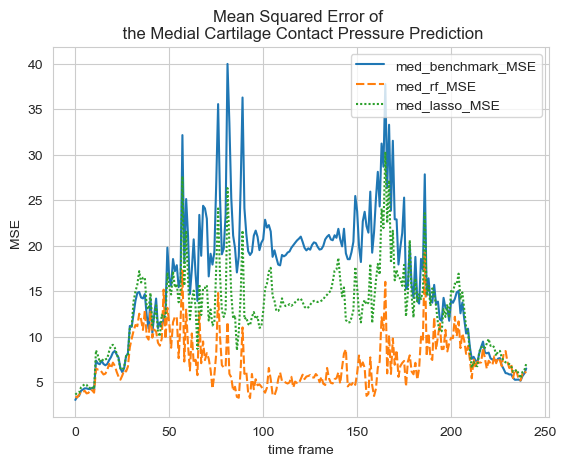

In [56]:
sns.lineplot(data=mse[["med_benchmark_MSE", "med_rf_MSE", "med_lasso_MSE"]]).\
    set(
        title='Mean Squared Error of \n the Medial Cartilage Contact Pressure Prediction',
        xlabel = "time frame", ylabel="MSE"
        )

[Text(0.5, 1.0, 'Mean Squared Error of \n the Lateral Cartilage Contact Pressure Prediction'),
 Text(0.5, 0, 'time frame'),
 Text(0, 0.5, 'MSE')]

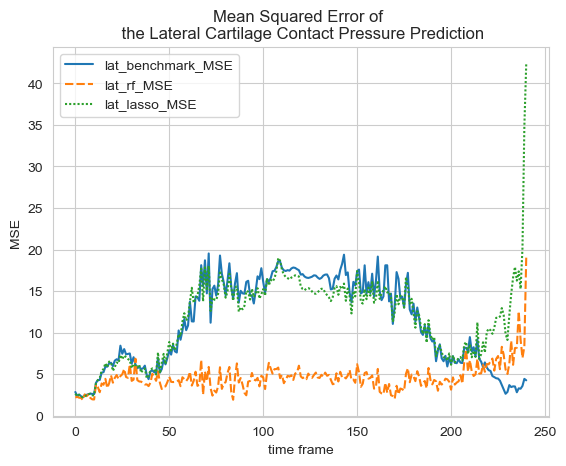

In [57]:
sns.lineplot(data=mse[["lat_benchmark_MSE", "lat_rf_MSE", "lat_lasso_MSE"]]).\
    set(
        title='Mean Squared Error of \n the Lateral Cartilage Contact Pressure Prediction',
        xlabel = "time frame", ylabel="MSE"
        )